In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


#theano imports
#the problem is too simple to be run on GPU. Seriously.
%env THEANO_FLAGS='device=cpu'
import theano
import theano.tensor as T
floatX = theano.config.floatX

import lasagne


env: THEANO_FLAGS='device=cpu'


In [2]:
%load_ext autoreload
%autoreload 2

# This tutorial explains the basic pipline of Agentnet experiment
* experiment setup
* designing agent
* interacting with environment
* computing losses
* training

# Experiment setup
* Here we load a simple experiment environment (description below)
* Designing one from scratch is explained in later tutorials

In [3]:
import agentnet.experiments.boolean_reasoning as experiment
print experiment.__doc__


This is a dummy experiment setup that requires agent to make advantage of
a simple logical formula in order to maximize expected reward.

The world agent exists in has a number of boolean hidden factors:
X1, X2, X3, Y1, Y2.

The factors are not independent. Namely,
 - Y1 is true if X1
 - Y2 is true if not X1

In the initial moment of time, agent knows nothing about any of them.
At each turn, agent may decide to
 - "open" one of the hidden factors.
   - if the factor turns out to be 1, agent receives +1 reward for X*, +3 for Y*
   - Otherwise, the reward equals -1 for X*, -3 for Y*
   - checking a single factor more than once a session will result in -0.5 reward for every attempt but for first one
 - decide to quit session
   - yields reward of 0 and ends the interaction.
   - all farther actions will have no effect until next session

It is expected, that in order to maximize it's expected reward, the agent
will learn the policy
1. Check X1
2. If X1, check Y1, else Y2

The experiment 

In [4]:
#Create an environment with all default parameters
env = experiment.BooleanReasoningEnvironment()

# agent setup
* An agent implementation has to contain three parts:
 * Memory layer(s)
  * in this case, a single one-step RNN
 * Q-values evaluation layers
  * in this case, a lasagne dense layer based on memory layer
 * Resolver - acton picker layer
  * in this case, the resolver has epsilon-greedy policy

In [5]:
from agentnet.resolver import EpsilonGreedyResolver
from agentnet.memory import RecurrentMemoryLayer
from agentnet.agent import Agent

In [6]:
import lasagne

#64 hidden neurons
n_hid=64


observation_size = (None,)+tuple(env.observation_shapes)

observation_layer = lasagne.layers.InputLayer(observation_size,name="obs_input")
prev_state_layer = lasagne.layers.InputLayer([None,n_hid],name="prev_state_input")

#memory
#note that this isn't the same as lasagne recurrent units (see next text tab for detail)
rnn = RecurrentMemoryLayer(prev_state_layer,
                           observation_layer,
                           name="rnn0")

#q_eval
q_eval = lasagne.layers.DenseLayer(rnn,
                                   num_units = env.n_actions,
                                   nonlinearity=lasagne.nonlinearities.linear,name="QEvaluator")

#resolver
epsilon = theano.shared(np.float32(0.1),name="e-greedy.epsilon")

resolver = EpsilonGreedyResolver(q_eval,epsilon=epsilon,name="resolver")


#all together
agent = Agent(observation_layer,
              {rnn:prev_state_layer},
              q_eval,resolver)


In [7]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[rnn0.hid_to_hid.W,
 rnn0.hid_to_hid.b,
 rnn0.input0_to_hid.W,
 QEvaluator.W,
 QEvaluator.b]

## Agent setup in detail
* __Memory layers__
 * One-step recurrent layer
     * takes input and one's previous state
     * returns new memory state
   * Can be arbitrary lasagne layer
   * Several one-step recurrent units are implemented in __agentnet.memory__
   * Note that lasagne's default recurrent networks roll for several steps at once
     * in other words, __using lasagne recurrent units as memory means recurrence inside recurrence__
 * Using more than one memory layer is explained in farther tutorials


* __Q-values evaluation layer__
 * Can be arbitrary lasagne network
 * returns predicted Q-values for each action
 * Usually depends on memory as an input


* __Resolver__ - action picker
 * Decides on what action is taken
 * Normally takes Q-values as input
 * Currently all experiments require integer output
 * Several resolver layers are implemented in __agentnet.resolver__

# Interacting with environment
* an agent has a method that produces symbolic environment interaction sessions
* Such sessions are represented as tensors with dimensions matching pattern [batch_session_i, time_tick, ...]
* interactions result in sequences of observations, actions, q-values,etc
* one has to pre-define maximum session length.
 * in this case, environment implements an indicator of whether session has ended by current tick
* Since this environment also implements Objective methods, it can evaluate rewards for each [batch, time_tick]


In [8]:
#produce interaction sequences of length <= 10
state_seq,observation_seq,agent_state,action_seq,qvalues_seq = agent.get_sessions(
    env,
    session_length=10,
    batch_size=env.batch_size,
)


hidden_seq = agent_state[rnn]

#get rewards for all actions
rewards_seq = env.get_reward_sequences(state_seq,action_seq)

#get indicator whether session is still active
is_alive_seq = env.get_whether_alive(observation_seq)


# Evaluating loss function
* In this case, we want to 
 * first get pairs of (predicted Qvalue, reference Qvalue) for all actions commited
 * second, define loss function
 * third, compute grad and update weights

#### Define loss functions

In [9]:
#get reference Qvalues according to Qlearning algorithm


from agentnet.learning import qlearning


#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = theano.shared(np.float32(1),name = 'q_learning_gamma')


squarred_Qerror = qlearning.get_elementwise_objective(
    qvalues_seq,
    action_seq,
    rewards_seq,
    is_alive_seq,
    gamma_or_gammas=gamma,)


mse_Qloss = squarred_Qerror.sum(axis = 1).mean()

In [10]:
#regularize network weights

from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver,l2)*10**-3

In [11]:
loss = mse_Qloss + reg_l2

#### Compute weight updates

In [12]:
updates = lasagne.updates.adadelta(loss,weights,learning_rate=0.1)

#### Some auxilary evaluation metrics

In [13]:
mean_session_reward = rewards_seq.sum(axis=1).mean()
#...

# Compile train and evaluation functions

In [14]:
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)

evaluation_fun = theano.function([],[loss,mse_Qloss,reg_l2,mean_session_reward])

# session visualization tools


* this is a completely optional step of visualizing agent's sessions as chains of actions
* usually useful to get insight on what worked and what din't
* in this case, we print strings following pattern
  * [action_name] ([predicted action qvalue]) -> reward [reference qvalue] | next iteration

* plot shows
    * time ticks over X, abstract values over Y
    * bold lines are Qvalues for actions
    * dots on bold lines represent what actions were taken at each moment of time
    * dashed lines are agent's hidden state neurons
    * blue vertical line - session end
    
    
__Warning! the visualization tools are underdeveloped and only allow simple operations.__

if you found yourself struggling to make it do what you want for 5 minutes, go write your own tool [and contribute it :)]


In [15]:
from agentnet.display.sessions import print_sessions
get_printables = theano.function([], [
        hidden_seq,qvalues_seq, action_seq,rewards_seq,is_alive_seq
    ])

def display_sessions(with_plots = False):
        
    hidden_log,qvalues_log,actions_log,reward_log, is_alive_log = get_printables()
    
    
    print_sessions(qvalues_log,actions_log,reward_log,
                   is_alive_seq = is_alive_log,
                   action_names=env.feature_names,
                  
                  plot_policy = with_plots)

session # 0
 End_session_now(qv = 1.30842065811) -> 0.0 | 



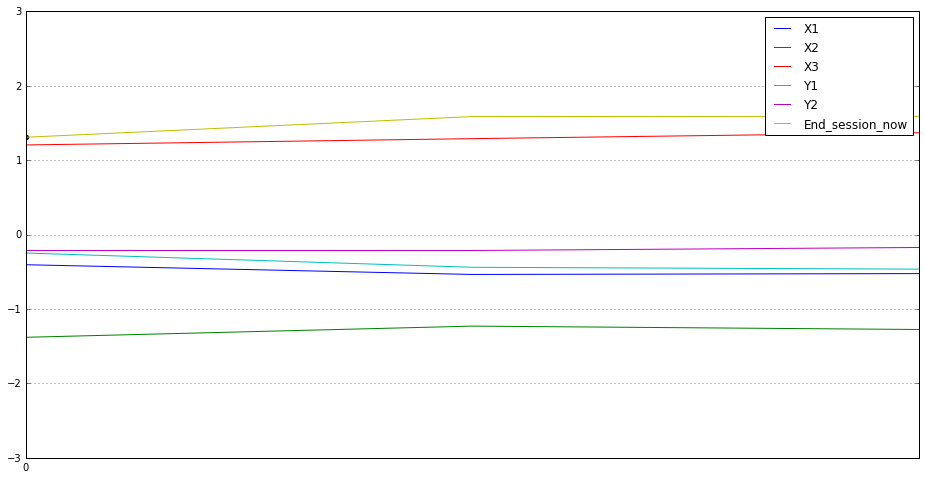

In [16]:
#visualize untrained network performance (which is mostly random)
env.generate_new_data_batch(1)
display_sessions(with_plots=True)

# Training loop

In [17]:
from agentnet.display import Metrics
score_log = Metrics()

In [18]:
#starting epoch
epoch_counter = 1

#moving average estimation
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

epoch 100,loss 10.01281, epsilon 0.96275, rewards: ( e-greedy -0.03500, greedy 0.00000) 
rec 9.924 reg 0.089
epoch 200,loss 11.49627, epsilon 0.92696, rewards: ( e-greedy -0.26650, greedy 0.00000) 
rec 11.408 reg 0.088
epoch 300,loss 1.08324, epsilon 0.89257, rewards: ( e-greedy -0.29985, greedy 0.00000) 
rec 0.996 reg 0.087
epoch 400,loss 7.19558, epsilon 0.85954, rewards: ( e-greedy -0.33986, greedy 0.00000) 
rec 7.109 reg 0.087
epoch 500,loss 5.19594, epsilon 0.82779, rewards: ( e-greedy -0.40588, greedy 0.00000) 
rec 5.110 reg 0.086
epoch 600,loss 5.33756, epsilon 0.79730, rewards: ( e-greedy -0.38029, greedy 0.06000) 
rec 5.252 reg 0.085
epoch 700,loss 7.19574, epsilon 0.76799, rewards: ( e-greedy -0.48226, greedy 0.03400) 
rec 7.111 reg 0.085
epoch 800,loss 11.51965, epsilon 0.73984, rewards: ( e-greedy -0.61404, greedy -0.00940) 
rec 11.435 reg 0.085
epoch 900,loss 8.06580, epsilon 0.71279, rewards: ( e-greedy -0.61263, greedy 0.03154) 
rec 7.982 reg 0.084
epoch 1000,loss 7.6776

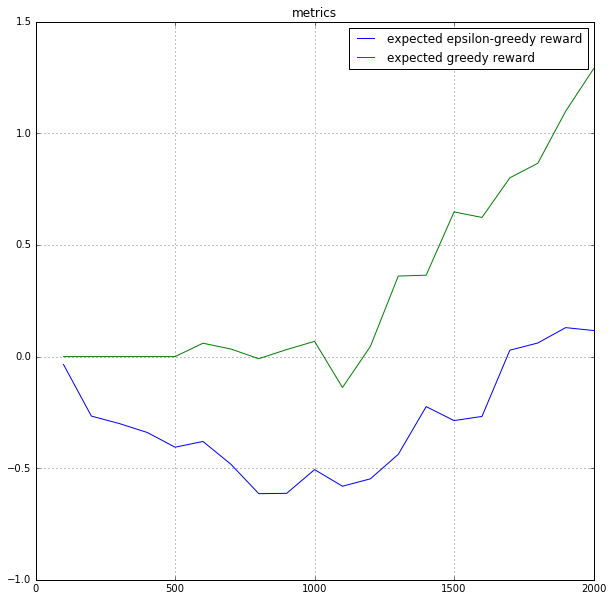

Random session examples
session # 0
 X1(qv = 0.764194190502) -> -1.0 |  X2(qv = -0.238588213921) -> 1.0 |  X3(qv = 0.0528364442289) -> -1.0 |  Y2(qv = 0.116103634238) -> 3.0 |  End_session_now(qv = 0.0146963410079) -> 0.0 | 



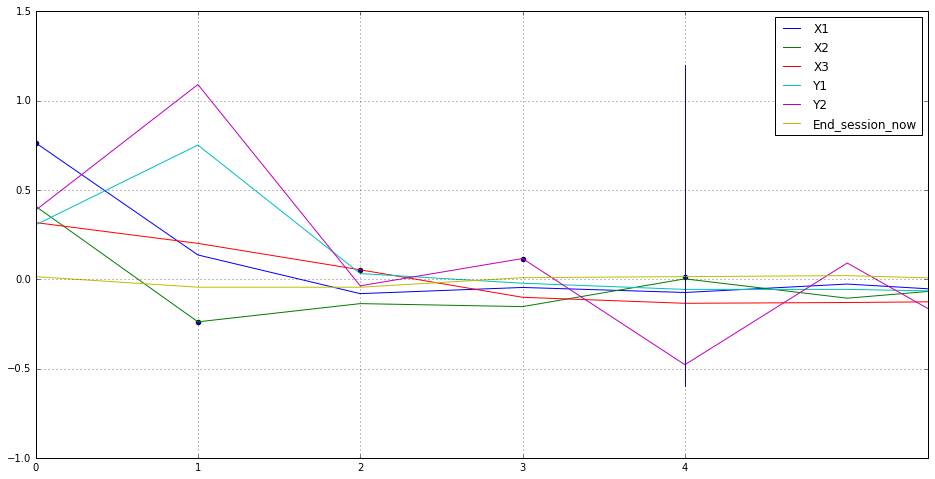

session # 1
 X1(qv = 0.764194190502) -> -1.0 |  X2(qv = -0.238588213921) -> 1.0 |  X3(qv = 0.0528364442289) -> 1.0 |  End_session_now(qv = 0.0258100144565) -> 0.0 | 



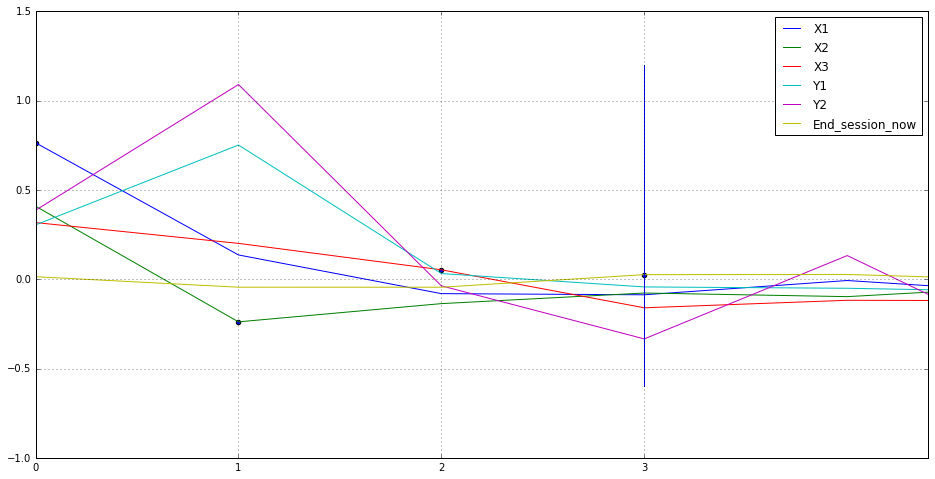

session # 2
 X3(qv = 0.31736266613) -> 1.0 |  X2(qv = -0.121236786246) -> -1.0 |  Y2(qv = 0.250047594309) -> -3.0 |  End_session_now(qv = 0.0102354548872) -> 0.0 | 



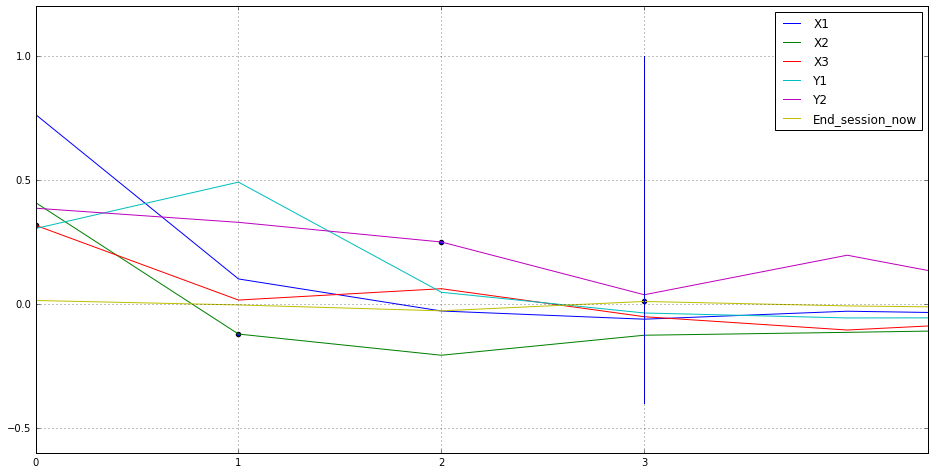

epoch 2100,loss 13.72787, epsilon 0.46012, rewards: ( e-greedy 0.10015, greedy 1.13552) 
rec 13.635 reg 0.093
epoch 2200,loss 9.84240, epsilon 0.44404, rewards: ( e-greedy 0.13513, greedy 1.31197) 
rec 9.747 reg 0.096
epoch 2300,loss 5.44174, epsilon 0.42859, rewards: ( e-greedy 0.24162, greedy 1.52077) 
rec 5.343 reg 0.099
epoch 2400,loss 9.00179, epsilon 0.41375, rewards: ( e-greedy 0.38746, greedy 1.66869) 
rec 8.901 reg 0.101
epoch 2500,loss 7.76052, epsilon 0.39949, rewards: ( e-greedy 0.40371, greedy 1.66182) 
rec 7.657 reg 0.103
epoch 2600,loss 9.10212, epsilon 0.38578, rewards: ( e-greedy 0.38334, greedy 1.77564) 
rec 8.998 reg 0.105
epoch 2700,loss 7.40430, epsilon 0.37262, rewards: ( e-greedy 0.34001, greedy 1.75808) 
rec 7.297 reg 0.107
epoch 2800,loss 7.30397, epsilon 0.35997, rewards: ( e-greedy 0.39101, greedy 1.87227) 
rec 7.195 reg 0.109
epoch 2900,loss 6.21436, epsilon 0.34781, rewards: ( e-greedy 0.50690, greedy 1.94504) 
rec 6.104 reg 0.111
epoch 3000,loss 7.89813, e

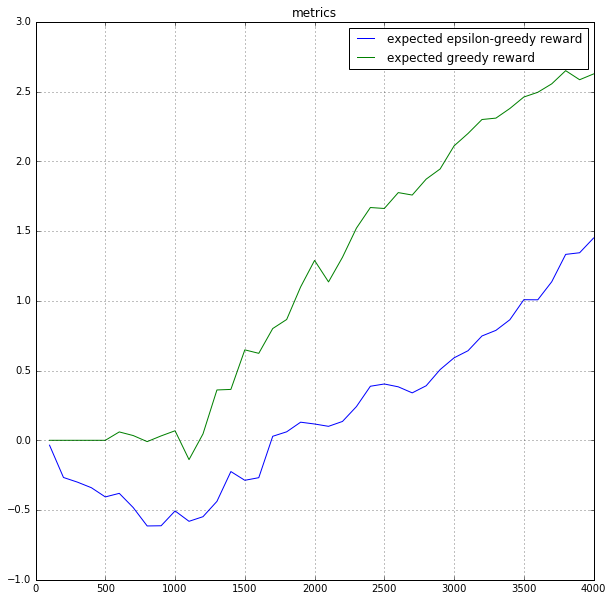

Random session examples
session # 0
 X1(qv = 2.47671031952) -> 1.0 |  Y1(qv = 2.39319634438) -> 3.0 |  End_session_now(qv = 0.00703061744571) -> 0.0 | 



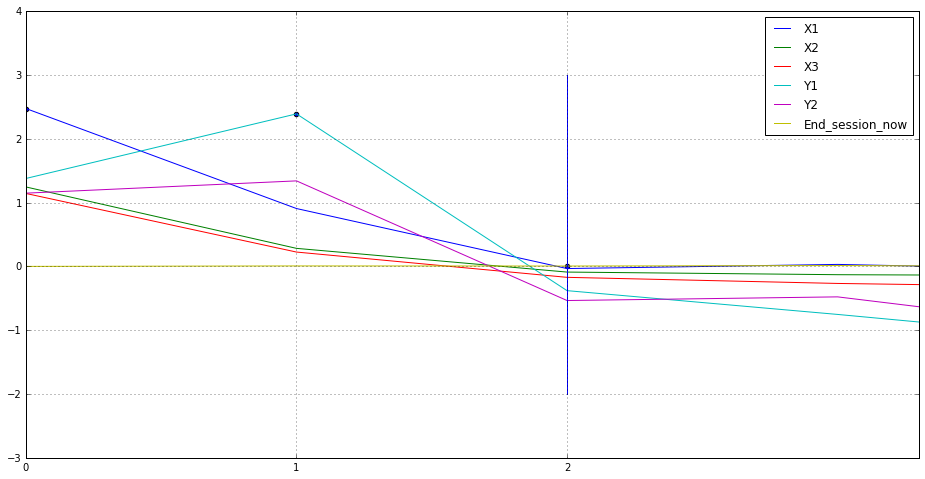

session # 1
 X1(qv = 2.47671031952) -> -1.0 |  Y2(qv = 2.59741330147) -> 3.0 |  End_session_now(qv = 0.00585624203086) -> 0.0 | 



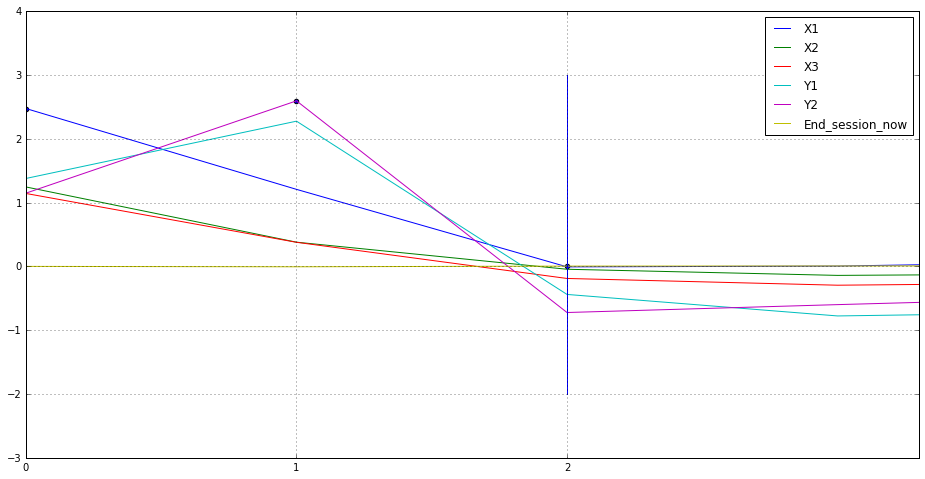

session # 2
 X1(qv = 2.47671031952) -> 1.0 |  Y1(qv = 2.39319634438) -> 3.0 |  End_session_now(qv = 0.00703057274222) -> 0.0 | 



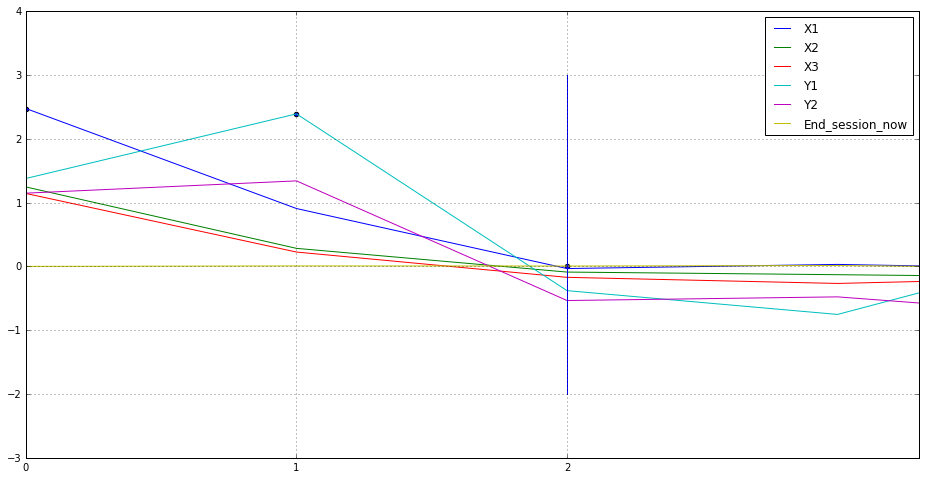

epoch 4100,loss 5.39638, epsilon 0.23428, rewards: ( e-greedy 1.47001, greedy 2.64363) 
rec 5.270 reg 0.126
epoch 4200,loss 2.40054, epsilon 0.22706, rewards: ( e-greedy 1.60801, greedy 2.65926) 
rec 2.273 reg 0.127
epoch 4300,loss 4.74118, epsilon 0.22011, rewards: ( e-greedy 1.58221, greedy 2.61834) 
rec 4.613 reg 0.128
epoch 4400,loss 2.63004, epsilon 0.21344, rewards: ( e-greedy 1.69399, greedy 2.62650) 
rec 2.500 reg 0.130
epoch 4500,loss 2.19934, epsilon 0.20703, rewards: ( e-greedy 1.82459, greedy 2.70385) 
rec 2.068 reg 0.131
epoch 4600,loss 3.90958, epsilon 0.20088, rewards: ( e-greedy 1.87713, greedy 2.75347) 
rec 3.777 reg 0.132
epoch 4700,loss 1.39392, epsilon 0.19496, rewards: ( e-greedy 1.92942, greedy 2.77812) 
rec 1.261 reg 0.133
epoch 4800,loss 5.09984, epsilon 0.18928, rewards: ( e-greedy 1.89147, greedy 2.78031) 
rec 4.965 reg 0.134
epoch 4900,loss 3.56468, epsilon 0.18382, rewards: ( e-greedy 1.96733, greedy 2.82228) 
rec 3.429 reg 0.136
epoch 5000,loss 3.95849, eps

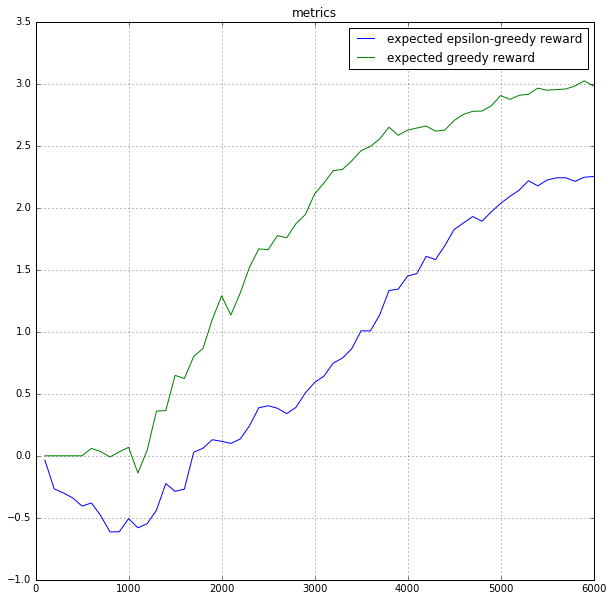

Random session examples
session # 0
 X1(qv = 2.94875764847) -> -1.0 |  Y2(qv = 2.8824236393) -> 3.0 |  End_session_now(qv = 0.00769542530179) -> 0.0 | 



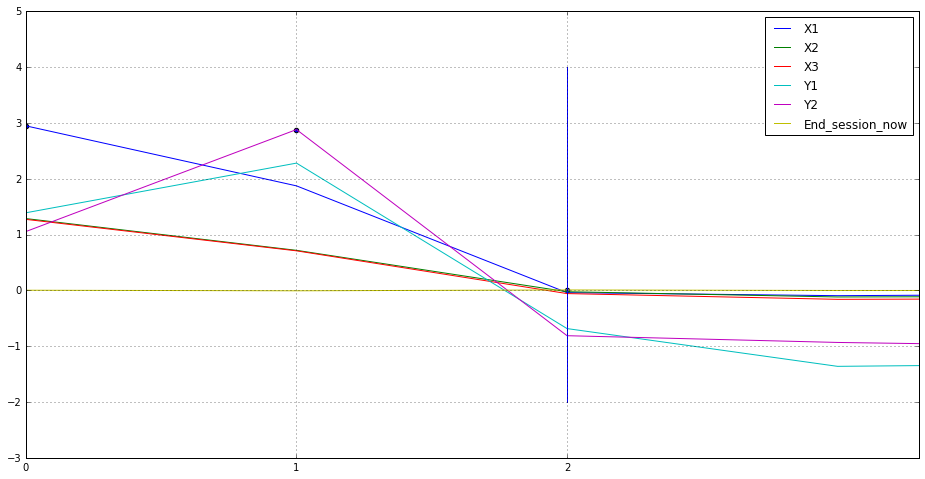

session # 1
 X1(qv = 2.94875764847) -> 1.0 |  Y1(qv = 2.87339520454) -> 3.0 |  End_session_now(qv = 0.00597067549825) -> 0.0 | 



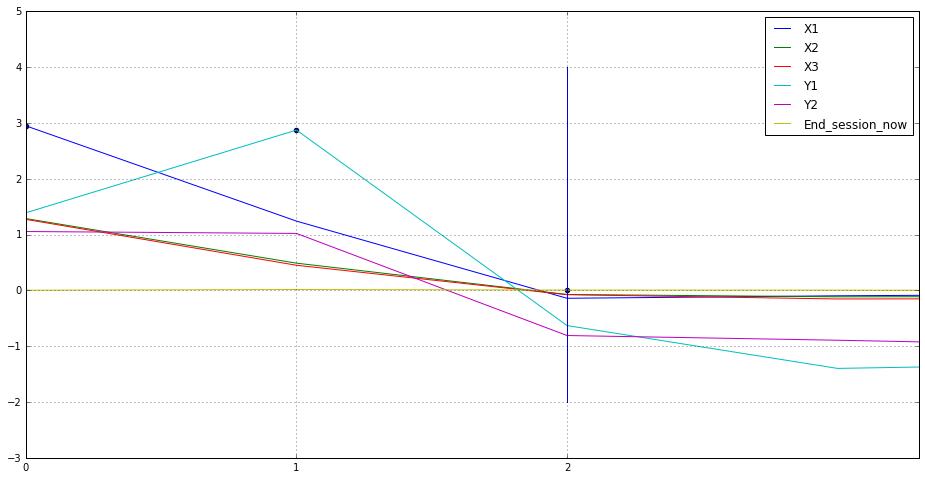

session # 2
 X2(qv = 1.28718161583) -> -1.0 |  Y2(qv = 1.62925922871) -> 3.0 |  End_session_now(qv = 0.013836722821) -> 0.0 | 



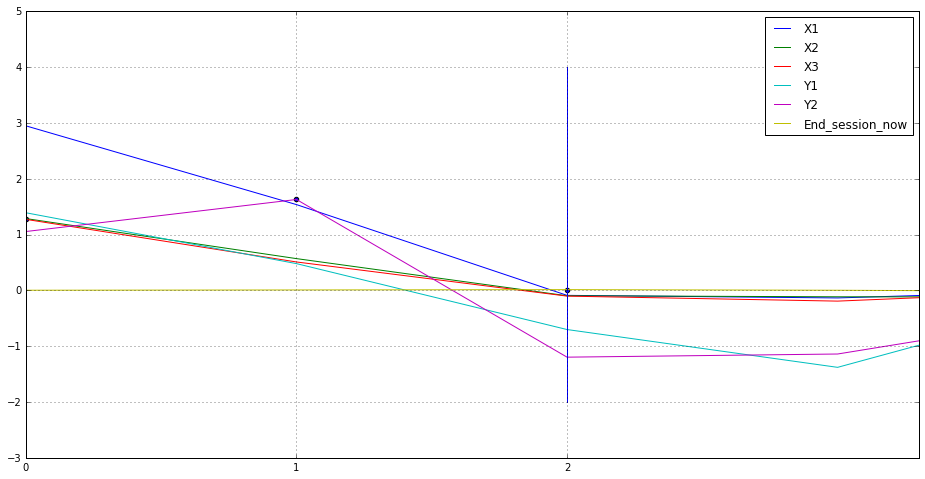

epoch 6100,loss 3.97023, epsilon 0.13280, rewards: ( e-greedy 2.17198, greedy 2.90849) 
rec 3.826 reg 0.144
epoch 6200,loss 2.29494, epsilon 0.12956, rewards: ( e-greedy 2.15478, greedy 2.86764) 
rec 2.150 reg 0.145
epoch 6300,loss 3.21897, epsilon 0.12644, rewards: ( e-greedy 2.19931, greedy 2.92088) 
rec 3.073 reg 0.146
epoch 6400,loss 2.01003, epsilon 0.12344, rewards: ( e-greedy 2.24438, greedy 2.90879) 
rec 1.864 reg 0.146
epoch 6500,loss 3.61457, epsilon 0.12056, rewards: ( e-greedy 2.23994, greedy 2.89791) 
rec 3.468 reg 0.147
epoch 6600,loss 1.16886, epsilon 0.11779, rewards: ( e-greedy 2.31094, greedy 2.90812) 
rec 1.022 reg 0.147
epoch 6700,loss 2.81953, epsilon 0.11513, rewards: ( e-greedy 2.37485, greedy 2.91731) 
rec 2.672 reg 0.148
epoch 6800,loss 1.97512, epsilon 0.11258, rewards: ( e-greedy 2.43236, greedy 2.92558) 
rec 1.827 reg 0.148
epoch 6900,loss 2.12927, epsilon 0.11013, rewards: ( e-greedy 2.38913, greedy 2.85302) 
rec 1.980 reg 0.149
epoch 7000,loss 1.43108, eps

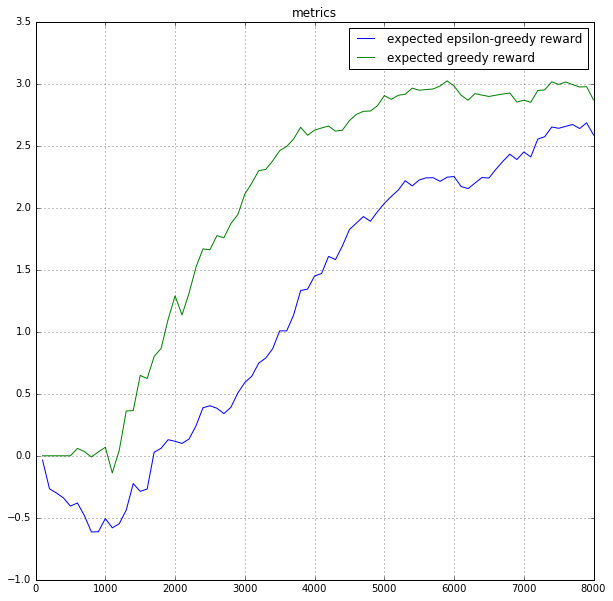

Random session examples
session # 0
 Y1(qv = 1.53992390633) -> 3.0 |  X1(qv = 1.309689641) -> 1.0 |  Y1(qv = 1.32600450516) -> -0.5 |  End_session_now(qv = -0.00809412822127) -> 0.0 | 



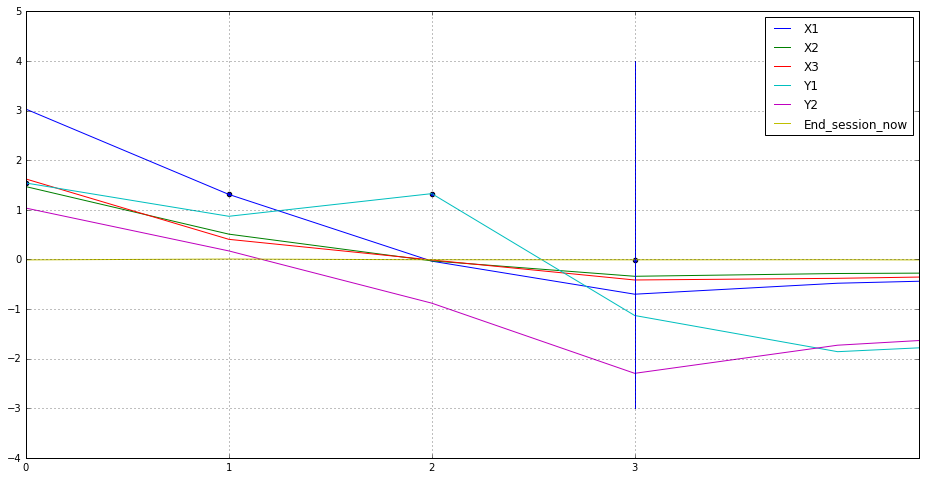

session # 1
 X1(qv = 3.02950167656) -> -1.0 |  Y2(qv = 3.02446365356) -> 3.0 |  X1(qv = 0.000682666897774) -> -0.5 |  X1(qv = -0.00995939970016) -> -0.5 |  Y2(qv = 0.0132652912289) -> -0.5 |  End_session_now(qv = -0.0157758370042) -> 0.0 | 



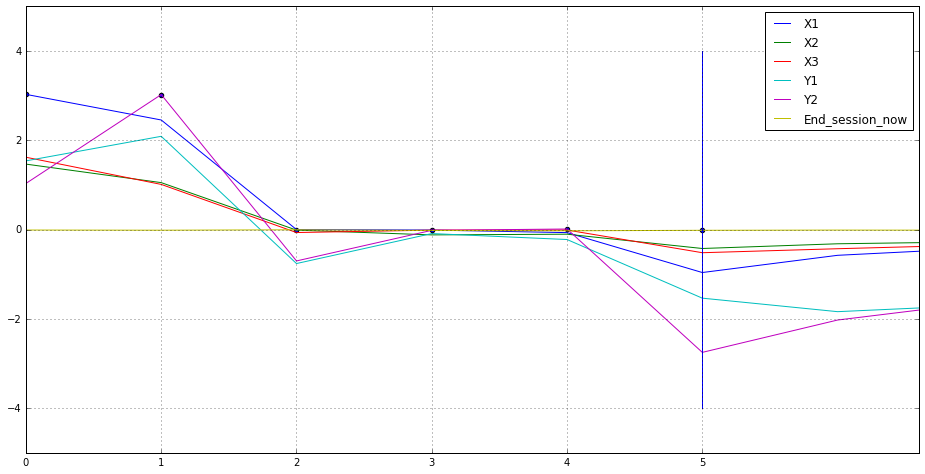

session # 2
 X1(qv = 3.02950167656) -> -1.0 |  Y2(qv = 3.02446317673) -> 3.0 |  X1(qv = 0.000682607293129) -> -0.5 |  X1(qv = -0.00995939970016) -> -0.5 |  Y2(qv = 0.0132649634033) -> -0.5 |  Y2(qv = -2.75016212463) -> -0.5 |  End_session_now(qv = -0.0200166627765) -> 0.0 | 



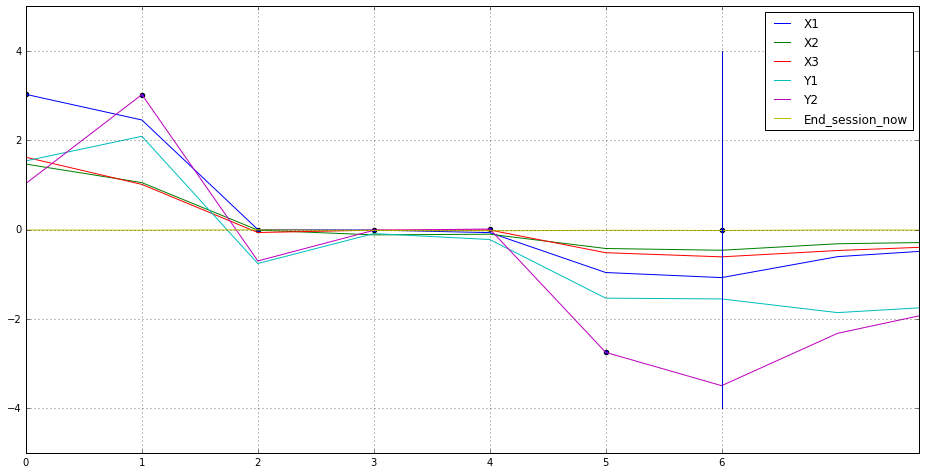

epoch 8100,loss 1.75646, epsilon 0.08721, rewards: ( e-greedy 2.61813, greedy 2.90220) 
rec 1.603 reg 0.153
epoch 8200,loss 1.89018, epsilon 0.08575, rewards: ( e-greedy 2.64631, greedy 2.91198) 
rec 1.737 reg 0.153
epoch 8300,loss 1.68056, epsilon 0.08435, rewards: ( e-greedy 2.55168, greedy 2.84078) 
rec 1.527 reg 0.154
epoch 8400,loss 2.30307, epsilon 0.08300, rewards: ( e-greedy 2.55151, greedy 2.85670) 
rec 2.149 reg 0.154
epoch 8500,loss 1.20531, epsilon 0.08170, rewards: ( e-greedy 2.63636, greedy 2.91103) 
rec 1.051 reg 0.154
epoch 8600,loss 1.39899, epsilon 0.08046, rewards: ( e-greedy 2.69273, greedy 2.95993) 
rec 1.245 reg 0.154
epoch 8700,loss 1.32399, epsilon 0.07927, rewards: ( e-greedy 2.73345, greedy 2.98394) 
rec 1.169 reg 0.155
epoch 8800,loss 1.21595, epsilon 0.07812, rewards: ( e-greedy 2.76011, greedy 3.02554) 
rec 1.061 reg 0.155
epoch 8900,loss 1.12182, epsilon 0.07702, rewards: ( e-greedy 2.75410, greedy 3.04299) 
rec 0.966 reg 0.155
epoch 9000,loss 1.85656, eps

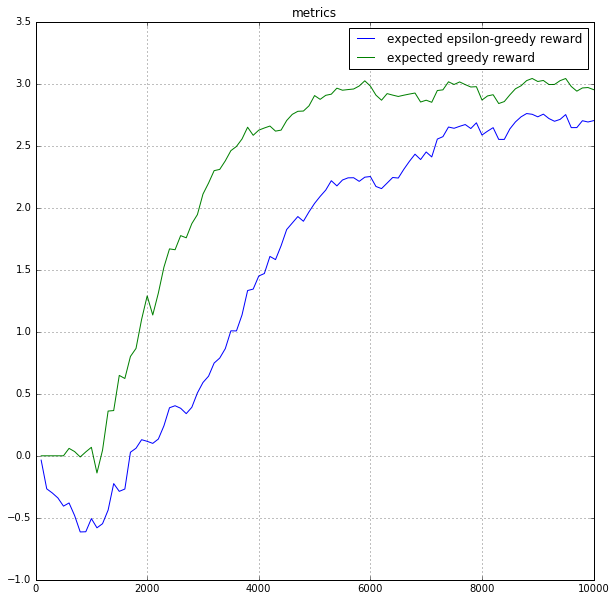

Random session examples
session # 0
 X1(qv = 2.97392845154) -> -1.0 |  Y2(qv = 3.06398296356) -> 3.0 |  X3(qv = 0.00034650368616) -> 1.0 |  End_session_now(qv = -0.0064643137157) -> 0.0 | 



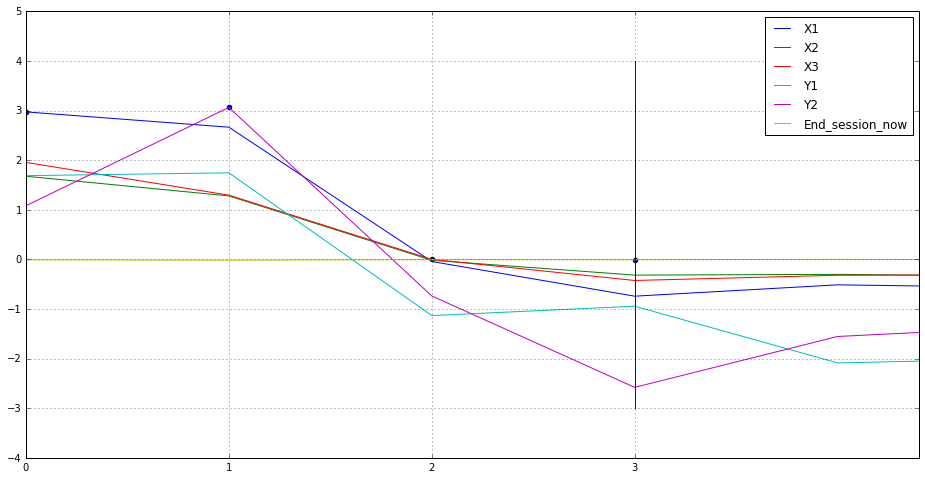

session # 1
 X1(qv = 2.97392845154) -> -1.0 |  Y2(qv = 3.06398296356) -> 3.0 |  X3(qv = 0.00034650368616) -> -1.0 |  End_session_now(qv = -0.0029011964798) -> 0.0 | 



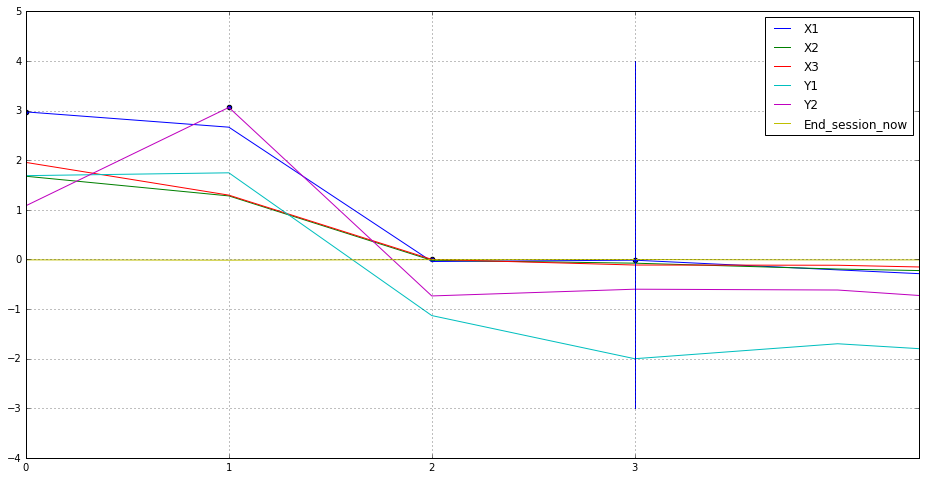

session # 2
 X1(qv = 2.97392845154) -> 1.0 |  Y1(qv = 2.90574359894) -> 3.0 |  End_session_now(qv = -0.0048542805016) -> 0.0 | 



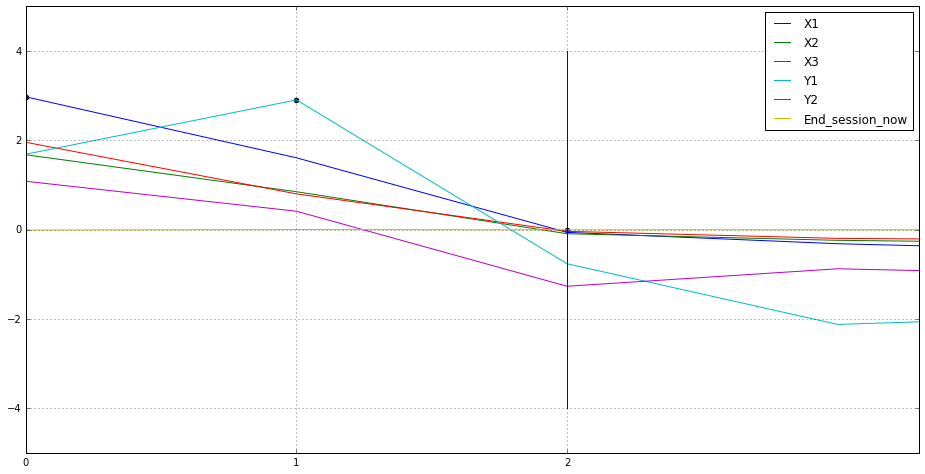

In [19]:
n_epochs = 10000
batch_size=10

for i in range(n_epochs):    
    
    #train
    env.generate_new_data_batch(batch_size)
    loss,avg_reward = train_fun()
    
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%10 ==0:
        current_epsilon =  0.05 + 0.95*np.exp(-epoch_counter/2500.)
        resolver.epsilon.set_value(np.float32(current_epsilon))
    
    
    
    ##show current learning progress
    if epoch_counter%100 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected epsilon-greedy reward"][epoch_counter] = ma_reward_current
        
        
        
        #greedy train
        resolver.epsilon.set_value(0)
        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        resolver.epsilon.set_value(np.float32(current_epsilon))

        print "epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy)
        print "rec %.3f reg %.3f"%(q_loss,l2_penalty)

        
    #visualize learning curve and sample sessions
    if epoch_counter %2000 ==0:
        print "Learning curves:"
        score_log.plot()
        
        print "Random session examples"
        env.generate_new_data_batch(3)
        display_sessions(with_plots=True)



        
        
    epoch_counter  +=1


# Evaluate results

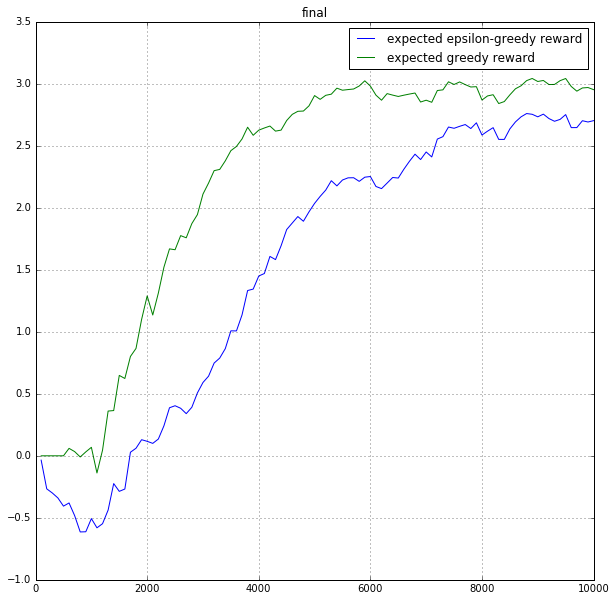

In [20]:
score_log.plot("final")

Random session examples
session # 0
 X1(qv = 2.97392892838) -> -1.0 |  Y2(qv = 3.06398296356) -> 3.0 |  X3(qv = 0.000346518587321) -> -1.0 |  End_session_now(qv = -0.0029011964798) -> 0.0 | 



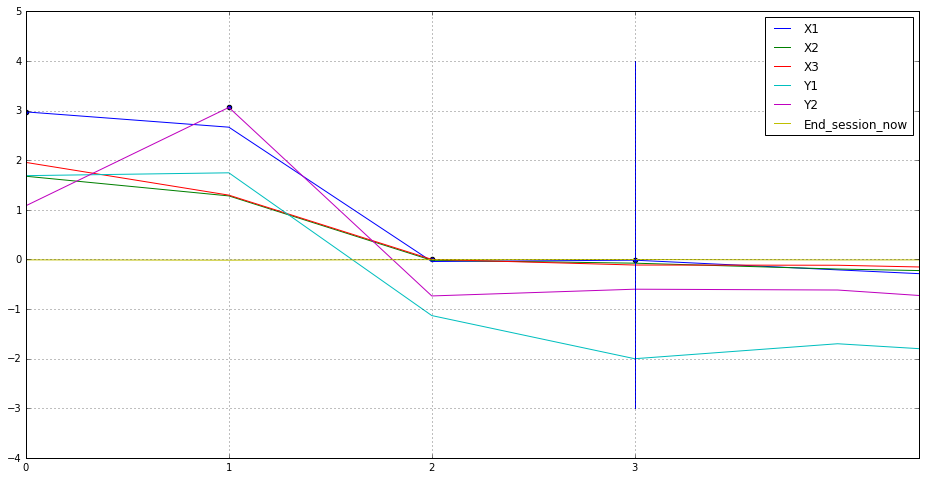

session # 1
 X1(qv = 2.97392892838) -> 1.0 |  Y1(qv = 2.90574359894) -> 3.0 |  End_session_now(qv = -0.00485427677631) -> 0.0 | 



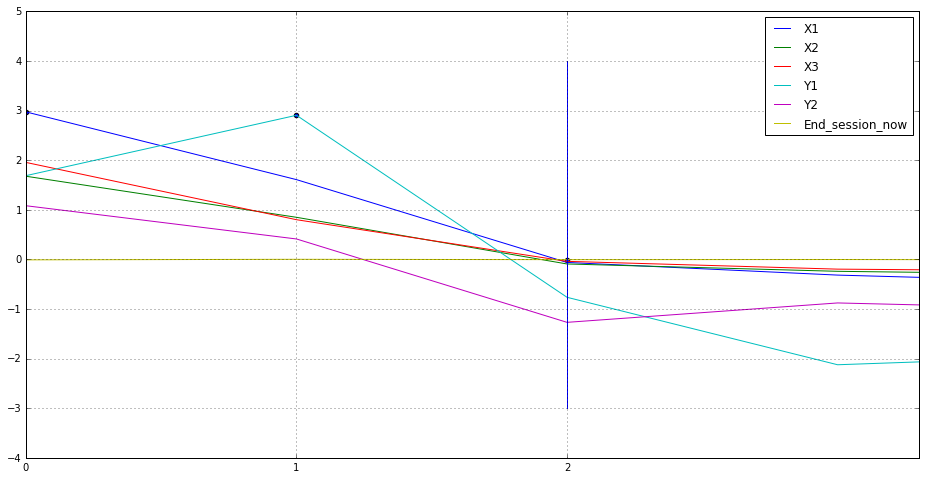

session # 2
 X1(qv = 2.97392892838) -> -1.0 |  Y2(qv = 3.06398296356) -> 3.0 |  X3(qv = 0.000346518587321) -> -1.0 |  End_session_now(qv = -0.0029011964798) -> 0.0 | 



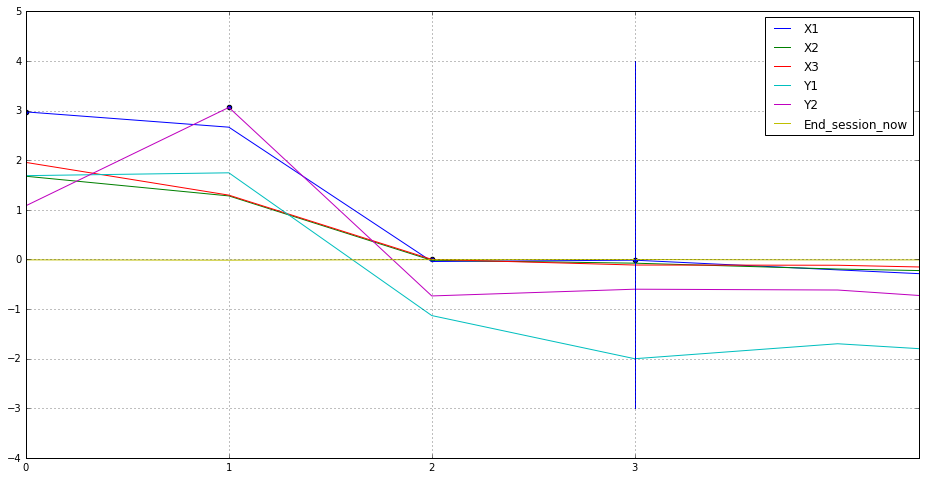

session # 3
 X1(qv = 2.97392892838) -> -1.0 |  Y2(qv = 3.06398296356) -> 3.0 |  X3(qv = 0.000346518587321) -> 1.0 |  End_session_now(qv = -0.0064643137157) -> 0.0 | 



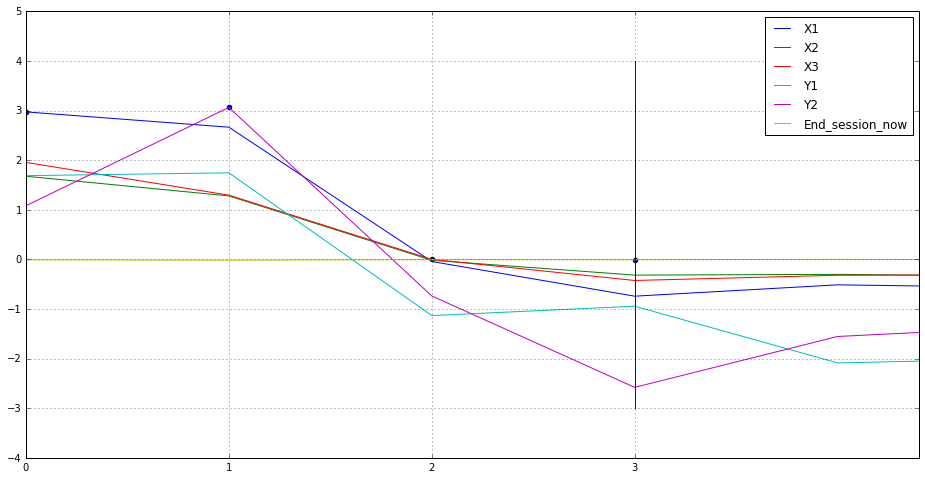

session # 4
 X1(qv = 2.97392892838) -> -1.0 |  Y2(qv = 3.06398296356) -> 3.0 |  X3(qv = 0.000346518587321) -> -1.0 |  End_session_now(qv = -0.0029011964798) -> 0.0 | 



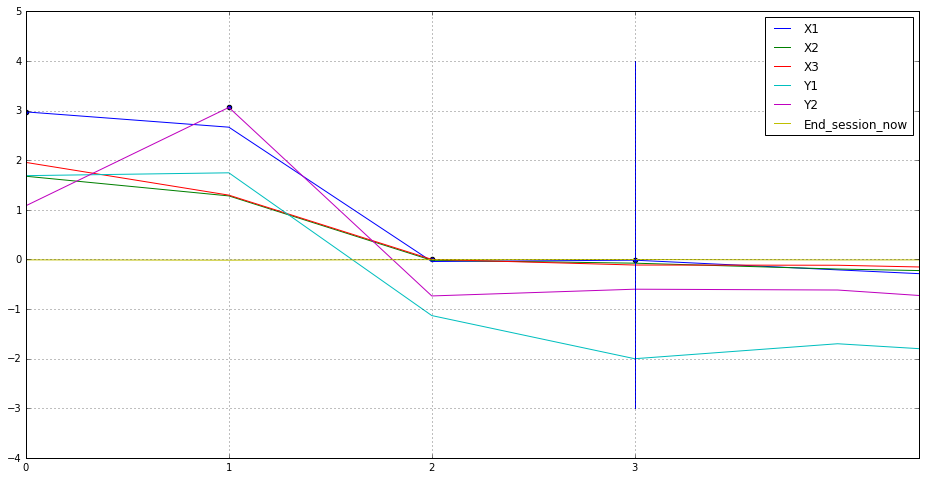

session # 5
 X1(qv = 2.97392892838) -> 1.0 |  Y1(qv = 2.90574359894) -> 3.0 |  End_session_now(qv = -0.00485427677631) -> 0.0 | 



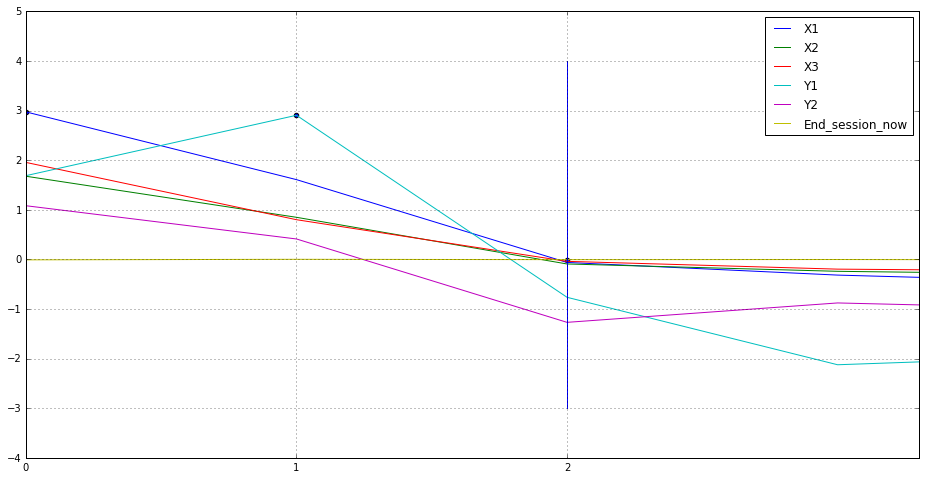

session # 6
 X1(qv = 2.97392892838) -> 1.0 |  Y1(qv = 2.90574359894) -> 3.0 |  End_session_now(qv = -0.00485427677631) -> 0.0 | 



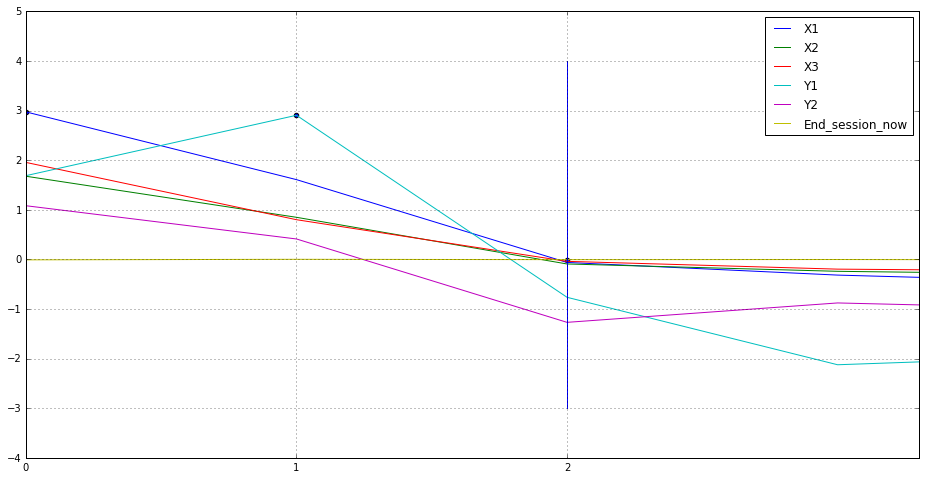

session # 7
 X1(qv = 2.97392892838) -> 1.0 |  Y1(qv = 2.90574359894) -> 3.0 |  End_session_now(qv = -0.00485427677631) -> 0.0 | 



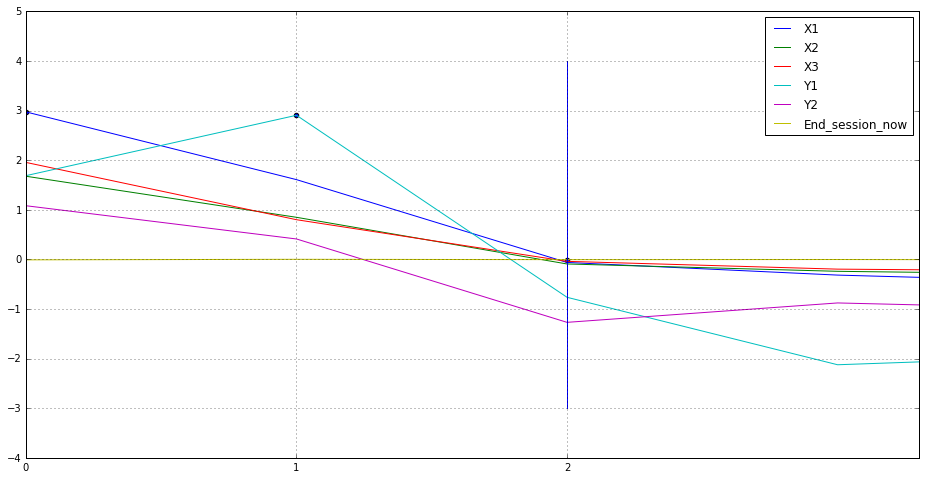

session # 8
 X1(qv = 2.97392845154) -> 1.0 |  Y1(qv = 2.90574336052) -> 3.0 |  End_session_now(qv = -0.00485427677631) -> 0.0 | 



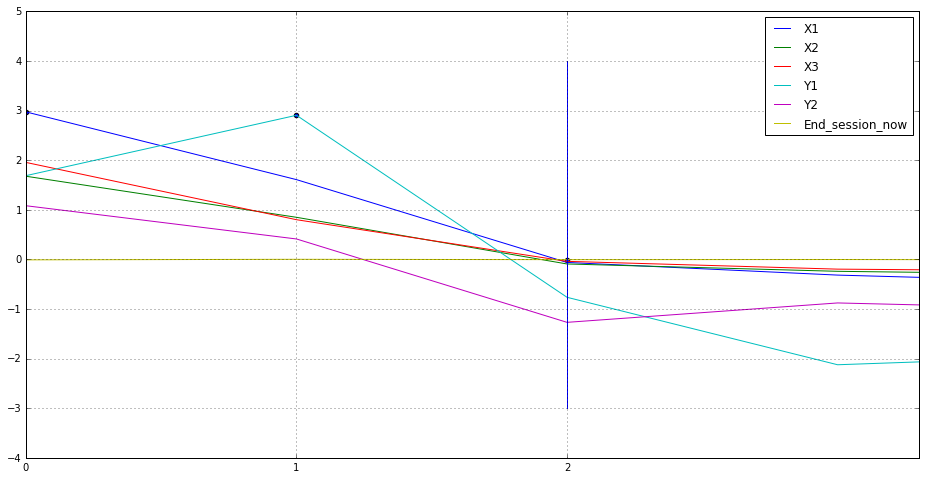

session # 9
 X1(qv = 2.97392845154) -> -1.0 |  Y2(qv = 3.06398296356) -> 3.0 |  X3(qv = 0.00034650368616) -> 1.0 |  End_session_now(qv = -0.0064643137157) -> 0.0 | 



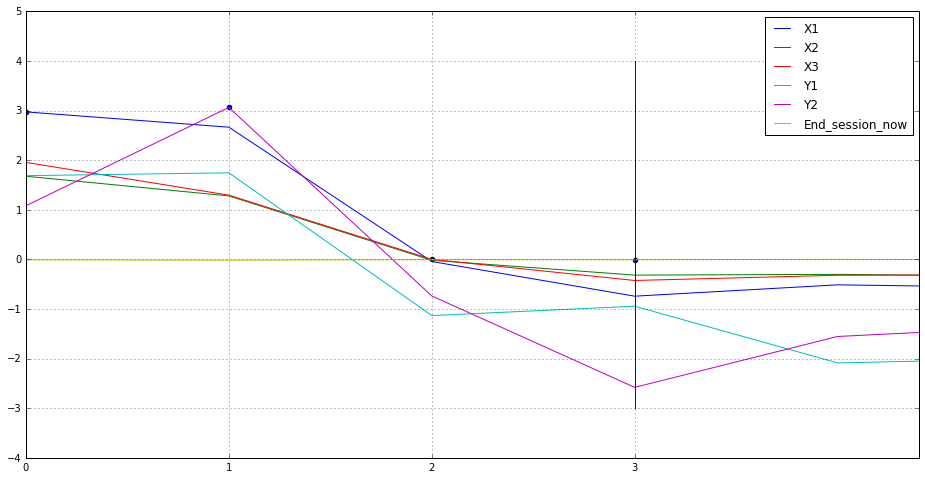

In [21]:
resolver.epsilon.set_value(np.float32(0.))
print "Random session examples"
env.generate_new_data_batch(10)
display_sessions(with_plots=True)
